In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [23]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=50

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [25]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds
    
    

In [26]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [27]:
len(train_ds)

54

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [30]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [31]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)                  

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)
    

Epoch 1/50
54/54 [==============================] - 146s 2s/step - loss: 0.8815 - accuracy: 0.5168 - val_loss: 0.8837 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 111s 2s/step - loss: 0.6705 - accuracy: 0.7112 - val_loss: 0.7396 - val_accuracy: 0.7188
Epoch 3/50
54/54 [==============================] - 113s 2s/step - loss: 0.4761 - accuracy: 0.7934 - val_loss: 0.4193 - val_accuracy: 0.8281
Epoch 4/50
54/54 [==============================] - 110s 2s/step - loss: 0.3319 - accuracy: 0.8669 - val_loss: 0.2334 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 112s 2s/step - loss: 0.3143 - accuracy: 0.8738 - val_loss: 0.3819 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 116s 2s/step - loss: 0.2615 - accuracy: 0.8976 - val_loss: 0.2660 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 117s 2s/step - loss: 0.2161 - accuracy: 0.9103 - val_loss: 0.1994 - val_accuracy: 0.8906
Epoch 8/50
54

In [34]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 289ms/step - loss: 0.0576 - accuracy: 0.9766


In [35]:
scores

[0.057558055967092514, 0.9765625]

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

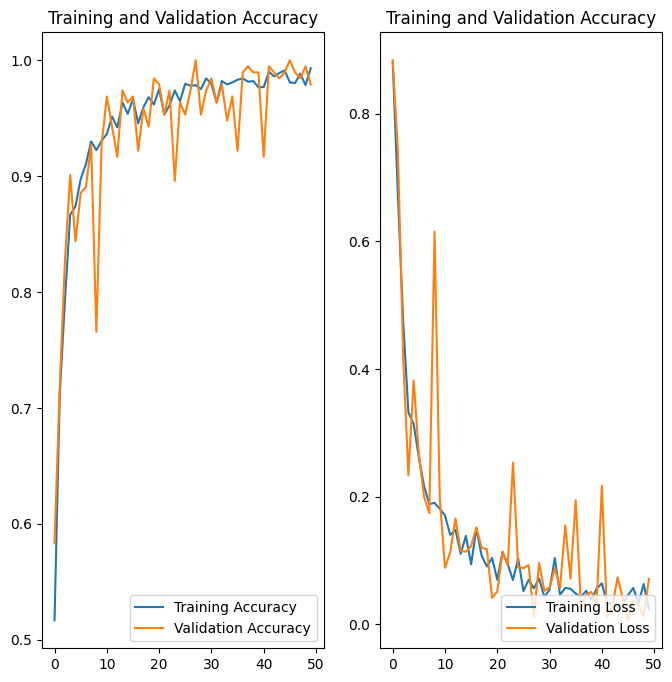

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [49]:
import numpy as np

In [50]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence
    

1/1 [==============================] - 0s 34ms/step


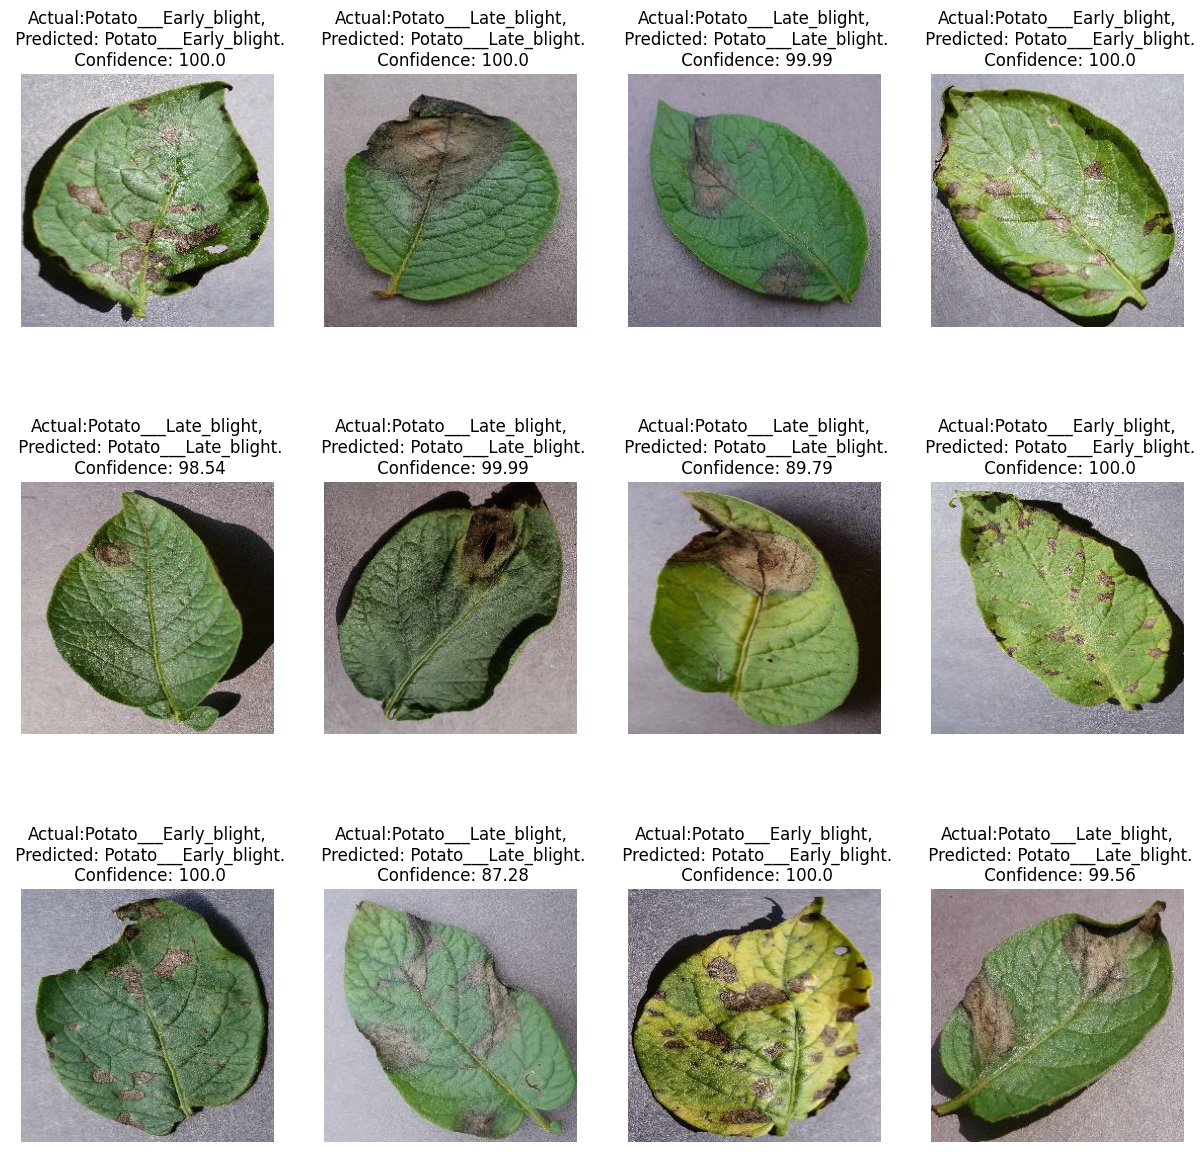

In [53]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")
        plt.axis("off")
        

In [46]:
class_names = dataset.class_names